In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import os

# Read the gold standard

In [2]:
allgsdf = pd.read_csv("../../resources/20180622processedGoldStandardTopics.tsv.gz", delimiter="\t")
gsdf = allgsdf.drop(["title", "abstract", "major_mesh", "minor_mesh"], axis=1)

# Read the result data

In [3]:
resdf = pd.read_csv("../../results_nomatchall/genedispbnb.trec_results", delimiter="\t", names=["topic", "Q0", "docid", "rank", "score", "run"])

# Join the results with the relevant GS documents
Because the goal of this is to see how well we were able to find an also rank the relevant documents

In [4]:
reljoin = pd.merge(gsdf.query("relevance_score > 0"), resdf, left_on="trec_doc_id", right_on="docid", how="left")

# Read the performance measures to compare with relevevant found statistics

In [5]:
stats = pd.read_csv("../../stats_nomatchall/OFFICIAL_genedispbnb.csv").set_index("Topic")
print("all infNDCG:", stats["infNDCG"]["all"])

all infNDCG: 0.4873


# Read the results into a map
This map then holds for each topic
* the **relevant documents**
* the **relevant found documents** (on **any rank**! Thus, this works beyond the 1k documents mark to which the `trec_eval` program is restricted)
* the **relevant not found** documents (again, also beyond the 1k mark)
* the **ranks of the relevant** topics

In [6]:
infos = {}

for topic in set(gsdf["trec_topic_number"]):
    gsreldocs      = set(gsdf.query("trec_topic_number == " + str(topic) +" and relevance_score > 0")["trec_doc_id"])
    res4topic      = resdf.query("topic == " + str(topic))
    reljoin4topic  = reljoin.query("topic == " + str(topic))
    allfoundseries = res4topic["docid"]
    resdocs        = set(allfoundseries)
  
    info = {}
    info["topic"]       = topic
    info["rel"]         = gsreldocs
    info["relfound"]    = gsreldocs.intersection(resdocs)
    info["relnotfound"] = gsreldocs.difference(resdocs)
    info["relranks"]    = list(reljoin4topic["rank"])
    info["score"]       = stats["infNDCG"][str(topic)]
    infos[topic] = info


# Plot the statistics calculated above

relfound       106.833333
relgs          129.166667
ranksmean       72.975805
ranksmedian     50.418333
dtype: float64

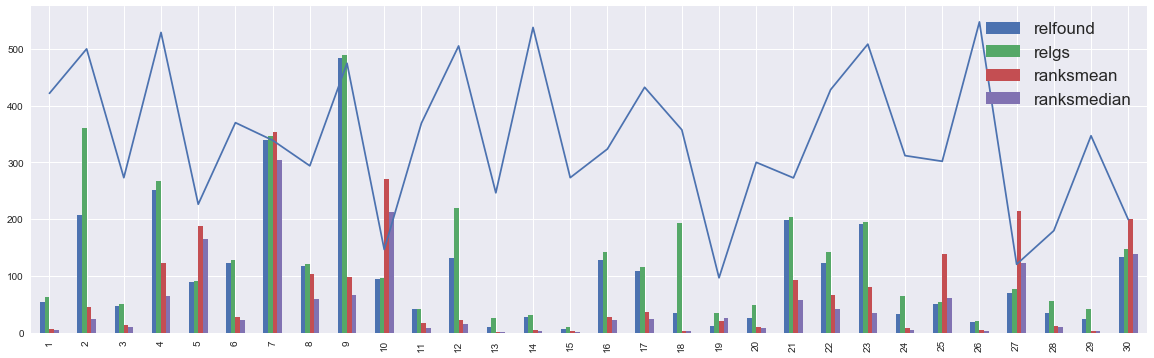

In [7]:
relfound    = []
relgs       = []
ranksmean   = []
ranksmedian = []
scores      = []
for topic in sorted(infos.keys()):
    info = infos[topic]
    relfound.append(len(info["relfound"]))
    relgs.append(len(info["rel"]))
    ranksmean.append(np.mean(info["relranks"])/10)
    ranksmedian.append(np.median(info["relranks"])/10)
    scores.append(infos[topic]["score"]*700)

df =  pd.DataFrame({"relfound": relfound, "relgs":relgs, "ranksmean":ranksmean, "ranksmedian": ranksmedian})
df.index = pd.Index(range(1,31))
axes =df.plot(kind="bar",figsize=(20,6))
axes.legend(prop={'size': 17});
axes.plot(range(0,30), scores)
df.mean()

In [8]:
from scipy.stats import pearsonr

In [9]:
print(pearsonr(scores, ranksmean))
print(pearsonr(scores, ranksmedian))

(-0.3073094184407465, 0.09854836127838787)
(-0.32346974516113614, 0.08121869251832996)


In [10]:
index = pd.Index(range(1,31))
relfounds = pd.Series(relfound, index=index)
relgss    = pd.Series(relgs, index=index)
ratio = relfounds/relgss
ratio.describe()

count    30.000000
mean      0.790523
std       0.231895
min       0.175258
25%       0.605682
50%       0.906487
75%       0.969531
max       0.988889
dtype: float64